# 프로젝트: 캐글 리더보드 정복하기

사용하는 캐글 competition : https://www.kaggle.com/c/2019-2nd-ml-month-with-kakr

# Cometition 정보

## 평가기준
RMSE(Root Mean Squared Error)
## Data fields
1. ID : 집을 구분하는 번호
2. date : 집을 구매한 날짜
3. price : 집의 가격(Target variable)
4. bedrooms : 침실의 수
5. bathrooms : 화장실의 수
6. sqft_living : 주거 공간의 평방 피트(면적)
7. sqft_lot : 부지의 평방 피트(면적)
8. floors : 집의 층 수
9. waterfront : 집의 전방에 강이 흐르는지 유무 (a.k.a. 리버뷰)
10. view : 집이 얼마나 좋아 보이는지의 정도
11. condition : 집의 전반적인 상태
12. grade : King County grading 시스템 기준으로 매긴 집의 등급
13. sqft_above : 지하실을 제외한 평방 피트(면적)
14. sqft_basement : 지하실의 평방 피트(면적)
15. yr_built : 지어진 년도
16. yr_renovated : 집을 재건축한 년도
17. zipcode : 우편번호
18. lat : 위도
19. long : 경도
20. sqft_living15 : 2015년 기준 주거 공간의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)
21. sqft_lot15 : 2015년 기준 부지의 평방 피트(면적, 집을 재건축했다면, 변화가 있을 수 있음)

# 데이터 준비하기

In [1475]:
import os
from os.path import join

import pandas as pd
import numpy as np

import missingno as msno

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold, cross_val_score
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns

In [1476]:
data_root_path = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
train_data_path = join(data_root_path, 'train.csv')
test_data_path = join(data_root_path, 'test.csv')

# EDA
https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12    
EDA 관해서 자세하게 설명하고 있어서 참고했습니다.

In [1477]:
train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)
train_data.shape, test_data.shape

((15035, 21), (6468, 20))

In [1478]:
train_data.head()

id             date     price  bedrooms  bathrooms  sqft_living  sqft_lot  \
0   0  20141013T000000  221900.0         3       1.00         1180      5650   
1   1  20150225T000000  180000.0         2       1.00          770     10000   
2   2  20150218T000000  510000.0         3       2.00         1680      8080   
3   3  20140627T000000  257500.0         3       2.25         1715      6819   
4   4  20150115T000000  291850.0         3       1.50         1060      9711   

   floors  waterfront  view  ...  grade  sqft_above  sqft_basement  yr_built  \
0     1.0           0     0  ...      7        1180              0      1955   
1     1.0           0     0  ...      6         770              0      1933   
2     1.0           0     0  ...      8        1680              0      1987   
3     2.0           0     0  ...      7        1715              0      1995   
4     1.0           0     0  ...      7        1060              0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711  

[5 rows x 21 columns]

* date : YYYYmmdd+T000000. 우리가 필요한 것은 YYYYmm 즉 앞의 6자리이다.
* yr_renovated : 0이라는 의미는 재건축을 하지 않았다는 것이다.

In [1479]:
test_data.head()

id             date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  15035  20141209T000000         3       2.25         2570      7242     2.0   
1  15036  20141209T000000         4       3.00         1960      5000     1.0   
2  15037  20140512T000000         4       4.50         5420    101930     1.0   
3  15038  20150415T000000         3       1.00         1780      7470     1.0   
4  15039  20150312T000000         3       2.50         1890      6560     2.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7        2170            400      1951   
1           0     0          5      7        1050            910      1965   
2           0     0          3     11        3890           1530      2001   
3           0     0          3      7        1050            730      1960   
4           0     0          3      7        1890              0      2003   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0          1991    98125  47.7210 -122.319           1690        7639  
1             0    98136  47.5208 -122.393           1360        5000  
2             0    98053  47.6561 -122.005           4760      101930  
3             0    98146  47.5123 -122.337           1780        8113  
4             0    98038  47.3684 -122.031           2390        7570

### 독립변수 시각화

In [1480]:
y = train_data['price']

In [1481]:
y.head()

0    221900.0
1    180000.0
2    510000.0
3    257500.0
4    291850.0
Name: price, dtype: float64

In [1482]:
y.describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

In [1483]:
sns.kdeplot(y)

<AxesSubplot:xlabel='price', ylabel='Density'>

분포를 살펴보면 한쪽으로 치우친 것을 볼 수 있으므로 log-scaling을 한다.

<AxesSubplot:xlabel='price', ylabel='Density'>

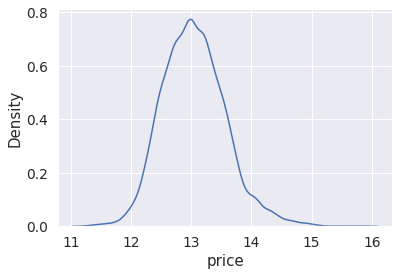

In [1484]:
y = np.log1p(y)
sns.kdeplot(y)

In [1485]:
train_data['price'] = y

### 종속변수 시각화

* 피어슨 : 연속형 변수
* 스피어만 : 순서형 변수. 범주형 변수도 포함되었을 경우 사용

price와 상관계수가 높은 것 10개만 시각화 한다.

In [1486]:
import scipy as sp

cor_abs = abs(train_data.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index

cor = np.array(sp.stats.spearmanr(train_data[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

그 결과 grade, sqft_living, sqft_living15, sqft_above 순으로 상관계수가 높다.    
lat(위도)가 들어가는데 이 노트북에서는 집값 데이터의 지역은 시애틀인데 시애틀은 위로 올라가면 갈수록 살기 좋은 집이 많다고 한다.

#### grade

<AxesSubplot:xlabel='grade', ylabel='price'>

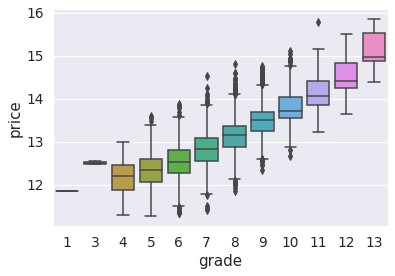

In [1487]:
sns.boxplot(data = train_data, x='grade', y='price')

##### 알 수 있는 것
* 등급이 높을 수록 가격이 올라간다.
* 등급 7-10까지 이상치가 많다.
* 등급 8과 11은 이상치가 크다.

#### sqft_living/sqft_living15/sqft_above

In [1488]:
sns.regplot(data=train_data, x='sqft_living', y='price')

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

##### 알 수 있는 것
* 선형적인 모양이다.
* price 2~3사이 이상치가 발견되었다.

<AxesSubplot:xlabel='sqft_living15', ylabel='price'>

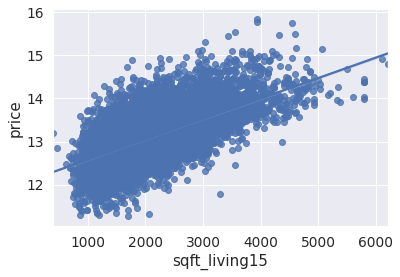

In [1489]:
sns.regplot(data=train_data, x='sqft_living15', y='price')

##### 알 수 있는 것
* sqft_living에 비해 분산이 크다.

<AxesSubplot:xlabel='sqft_above', ylabel='price'>

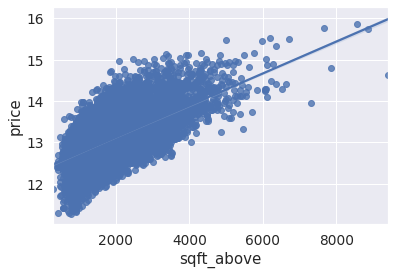

In [1490]:
sns.regplot(data=train_data, x='sqft_above', y='price')

##### 알 수 있는 것
* sqft_living과 모양이 비슷해보인다.

#### bathrooms

<AxesSubplot:xlabel='bathrooms', ylabel='price'>

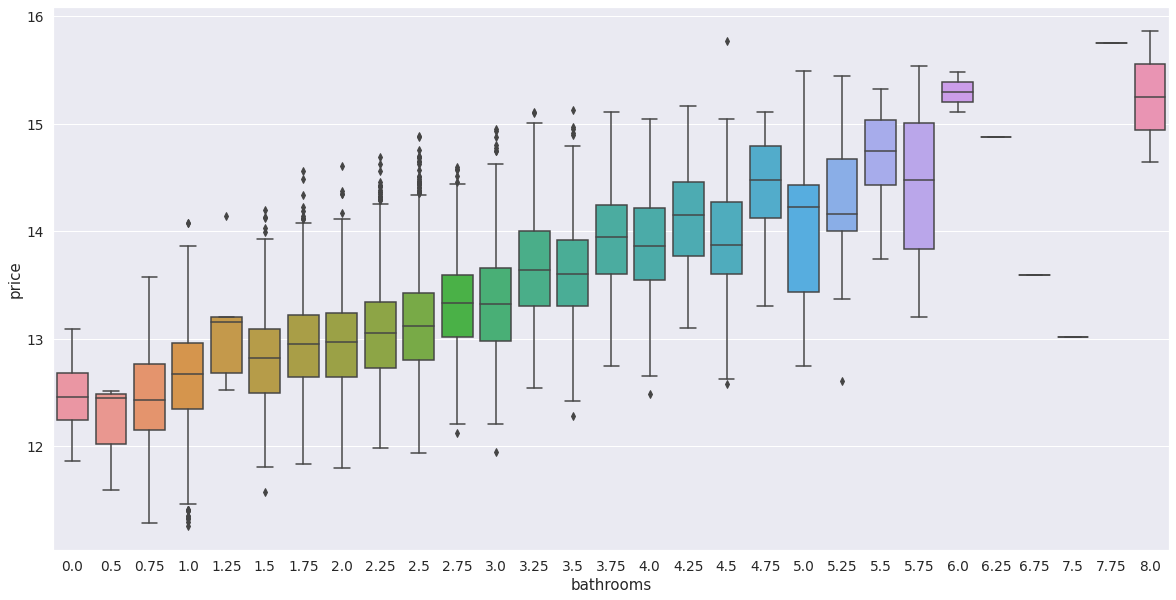

In [1491]:
plt.figure(figsize=(20,10))
sns.boxplot(data = train_data, x='bathrooms', y='price')

#### bedrooms

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

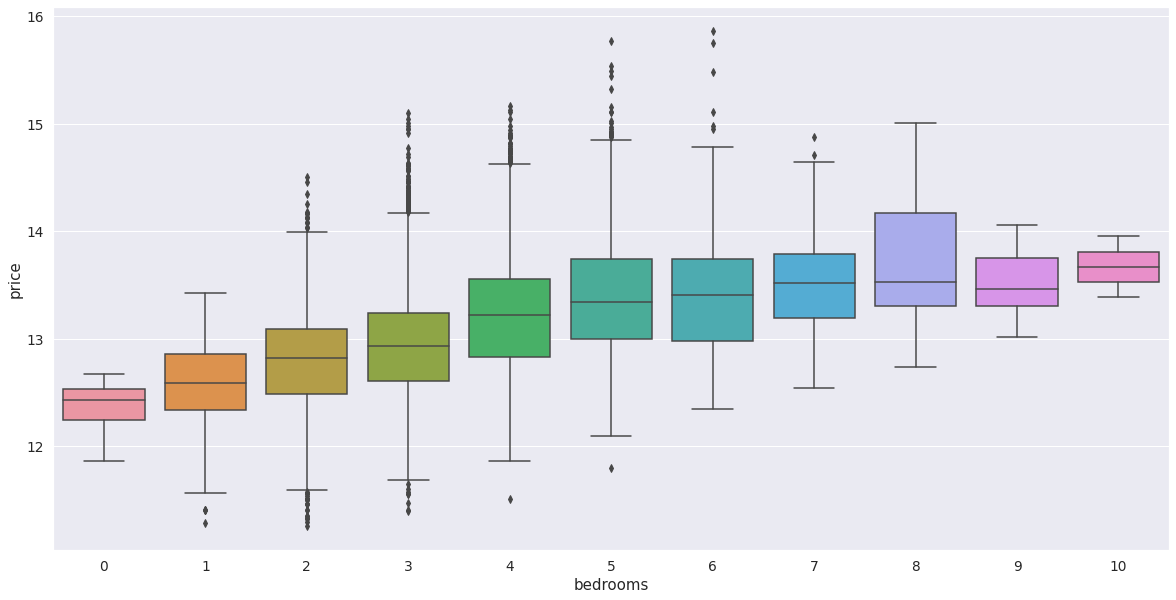

In [1492]:
plt.figure(figsize=(20,10))
sns.boxplot(data = train_data, x='bedrooms', y='price')

#### floors/view

<AxesSubplot:xlabel='floors', ylabel='price'>

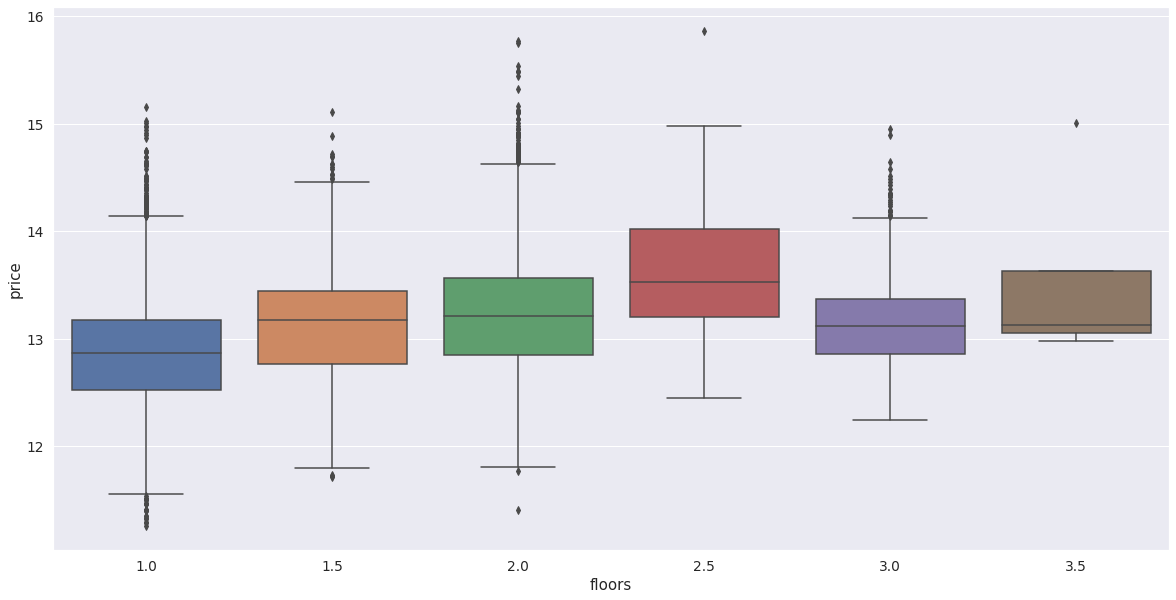

In [1493]:
plt.figure(figsize=(20,10))
sns.boxplot(data = train_data, x='floors', y='price')

##### 알 수 있는 것
* 선형적인 관계를 찾지 못했다.

<AxesSubplot:xlabel='view', ylabel='price'>

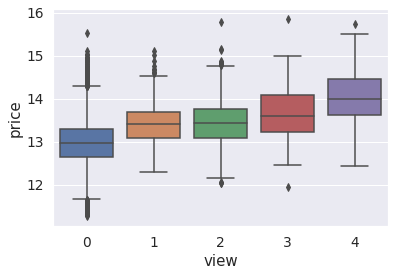

In [1494]:
sns.boxplot(data = train_data, x='view', y='price')

##### 알 수 있는 것
* view 타입이 각각 어떤 것을 의미하는지는 모르겠지만 숫자가 커질수록 가격이 올라가는 선형적인 관계이다.

### 결측치 확인

<AxesSubplot:>

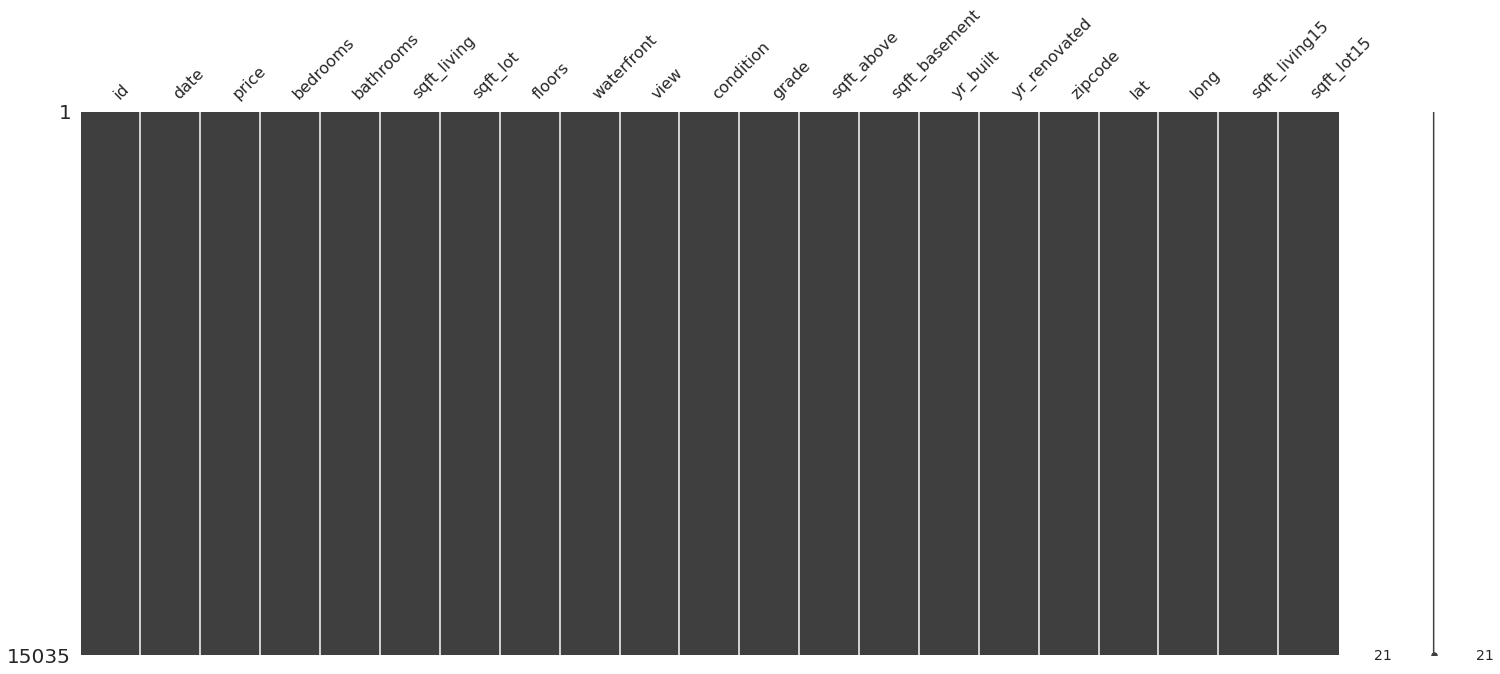

In [1495]:
msno.matrix(train_data)

In [1496]:
train_data.isnull().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

모든 컬럼에 결측치가 없는 것을 알 수 있다.

### 유니크한 값 확인
카테고리형 데이터로 보이는 특징들의 유니크한 값을 확인해보자.

<AxesSubplot:xlabel='Columns', ylabel='Unique_value'>

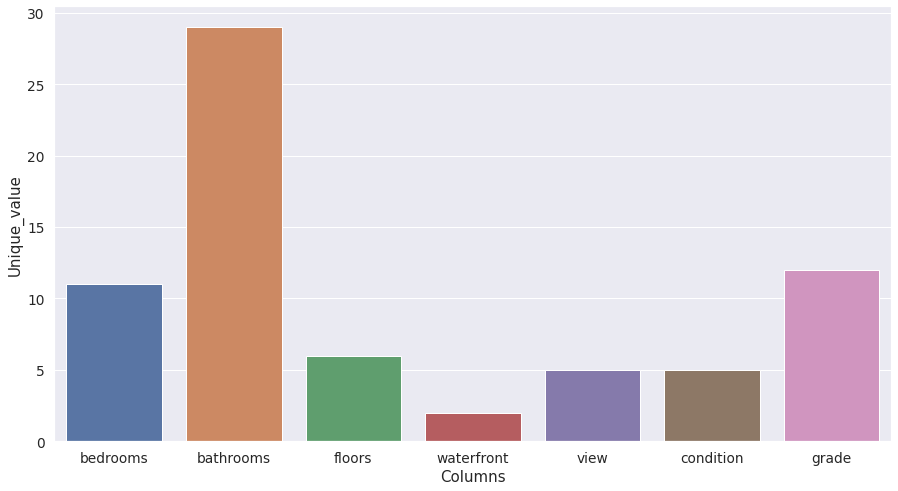

In [1497]:
categorical_field = ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade']
train_unique=[]
for field in categorical_field:
    train_unique.append(len(train_data[field].unique()))
    
unique_train=pd.DataFrame()
unique_train['Columns'] = categorical_field
unique_train['Unique_value']=train_unique

plt.figure(figsize=(15,8))
sns.barplot(data=unique_train, x='Columns', y='Unique_value')

In [1498]:
for field in categorical_field:
    print(field)
    print(sorted(train_data[field].unique()))

bedrooms
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
bathrooms
[0.0, 0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0, 4.25, 4.5, 4.75, 5.0, 5.25, 5.5, 5.75, 6.0, 6.25, 6.75, 7.5, 7.75, 8.0]
floors
[1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
waterfront
[0, 1]
view
[0, 1, 2, 3, 4]
condition
[1, 2, 3, 4, 5]
grade
[1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


# 데이터 전처리

### 이상치 제거

시각화를 했을 때 아래 변수들에 대해 이상치가 존재하는 것을 확인했다.
* sqft_living, grade, bedrooms

#### sqft_living

<AxesSubplot:xlabel='sqft_living', ylabel='price'>

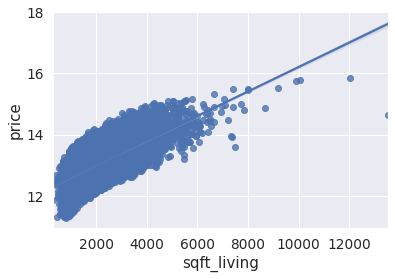

In [1499]:
sns.regplot(data=train_data, x='sqft_living', y='price')

In [1500]:
train_data.loc[train_data['sqft_living']>13000]

id             date      price  bedrooms  bathrooms  sqft_living  \
8912  8912  20140505T000000  14.639686         7        8.0        13540   

      sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
8912    307752     3.0           0     4  ...     12        9410   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
8912           4130      1999             0    98053  47.6675 -121.986   

      sqft_living15  sqft_lot15  
8912           4850      217800  

[1 rows x 21 columns]

index 8912의 경우 가격에 비해 sqft_living도 크고, price와 상관성이 높은 grade와 다른 평수들을 살펴봐도 큰 의미는 없어보이므로 제거한다. (큰 의미가 없는지 어떻게 판단한 것인지 궁금하다.)

In [1501]:
train_data = train_data.loc[train_data['id'] != 8912]

#### grade

<AxesSubplot:xlabel='grade', ylabel='price'>

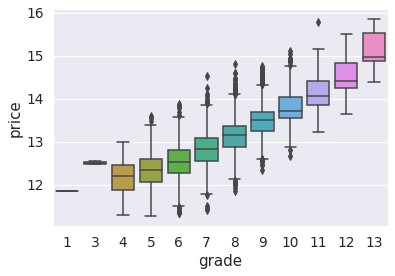

In [1502]:
sns.boxplot(data = train_data, x='grade', y='price')

grade=11, price>15.5 인 데이터가 유독 튀는 부분임을 발견했다.    
데이터를 확인해보면

In [1503]:
train_data.loc[(train_data['grade']==11) & (train_data['price']>15.5)]

id             date     price  bedrooms  bathrooms  sqft_living  \
2775  2775  20140611T000000  15.77031         5        4.5        10040   

      sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
2775     37325     2.0           1     2  ...     11        7680   

      sqft_basement  yr_built  yr_renovated  zipcode    lat     long  \
2775           2360      1940          2001    98004  47.65 -122.214   

      sqft_living15  sqft_lot15  
2775           3930       25449  

[1 rows x 21 columns]

In [1504]:
train_data.loc[(train_data['grade']==8) & (train_data['price']>14.7)]

id             date      price  bedrooms  bathrooms  sqft_living  \
7173  7173  20140813T000000  14.808763         5        4.0         4230   

      sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
7173     27295     2.0           1     4  ...      8        3230   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
7173           1000      1949          1985    98033  47.6803 -122.214   

      sqft_living15  sqft_lot15  
7173           2660       27295  

[1 rows x 21 columns]

grade=3, price>12 인 데이터를 확인해보면    
중요한 특징인 sqft_living과 grade가 모두 낮은 것을 확인할 수 있다.

In [1505]:
train_data.loc[(train_data['price']>12) & (train_data['grade'] == 3)]

id             date      price  bedrooms  bathrooms  sqft_living  \
2302  2302  20150225T000000  12.476104         1       0.75          520   
4123  4123  20141104T000000  12.542548         1       0.00          600   

      sqft_lot  floors  waterfront  view  ...  grade  sqft_above  \
2302     12981     1.0           0     0  ...      3         520   
4123     24501     1.0           0     0  ...      3         600   

      sqft_basement  yr_built  yr_renovated  zipcode      lat     long  \
2302              0      1920             0    98022  47.2082 -121.995   
4123              0      1950             0    98045  47.5316 -121.749   

      sqft_living15  sqft_lot15  
2302           1340       12233  
4123            990       22549  

[2 rows x 21 columns]

위의 값들을 이상치로 분류하고 삭제하였다.

In [1506]:
train_data = train_data.loc[train_data['id']!=2775]
train_data = train_data.loc[train_data['id']!=7173]
train_data = train_data.loc[train_data['id']!=2302]
train_data = train_data.loc[train_data['id']!=4123]

<AxesSubplot:xlabel='grade', ylabel='price'>

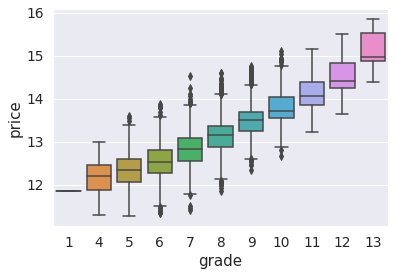

In [1507]:
sns.boxplot(data = train_data, x='grade', y='price')

#### bedrooms

<AxesSubplot:xlabel='bedrooms', ylabel='price'>

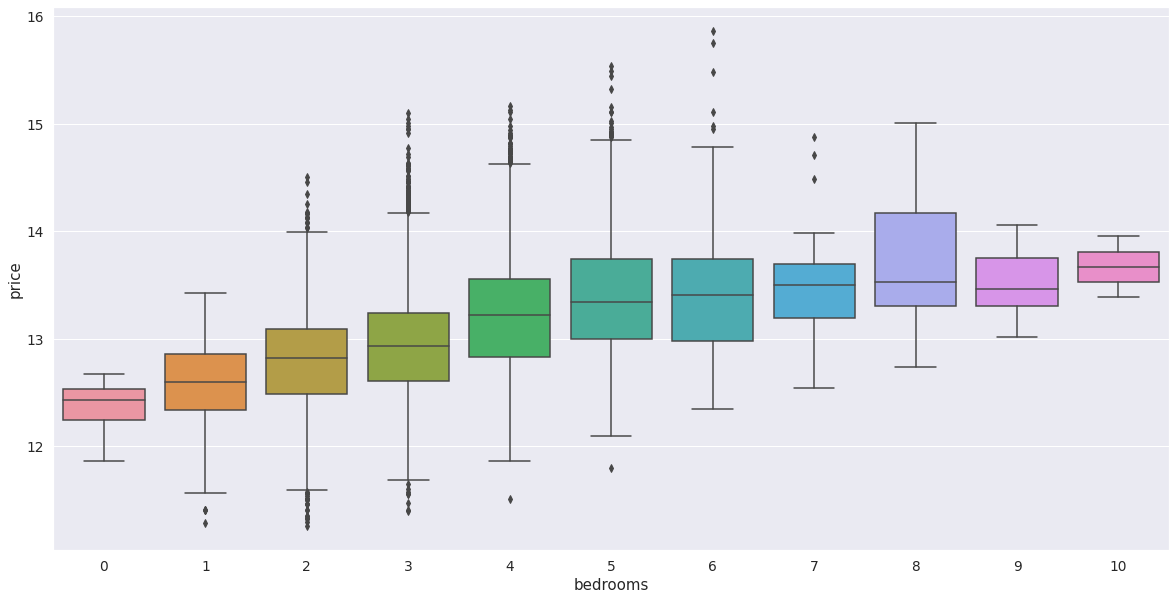

In [1508]:
plt.figure(figsize=(20,10))
sns.boxplot(data = train_data, x='bedrooms', y='price')

median이 양의 상관관계를 띄고 있고, bedrooms가 2~6은 분산이 크지만 다른 변수들의 영향이 크므로 제거하지 않기로 했다.

### 정규화

정규화 하기 전 train과 test의 데이터를 합쳐서 진행한다.

In [1509]:
train_len = len(train_data)
total_data = pd.concat((train_data, test_data), axis=0)
y = train_data['price']
del total_data['price']
print(f'{train_data.shape}+{test_data.shape} = {total_data.shape}')

(15030, 21)+(6468, 20) = (21498, 20)


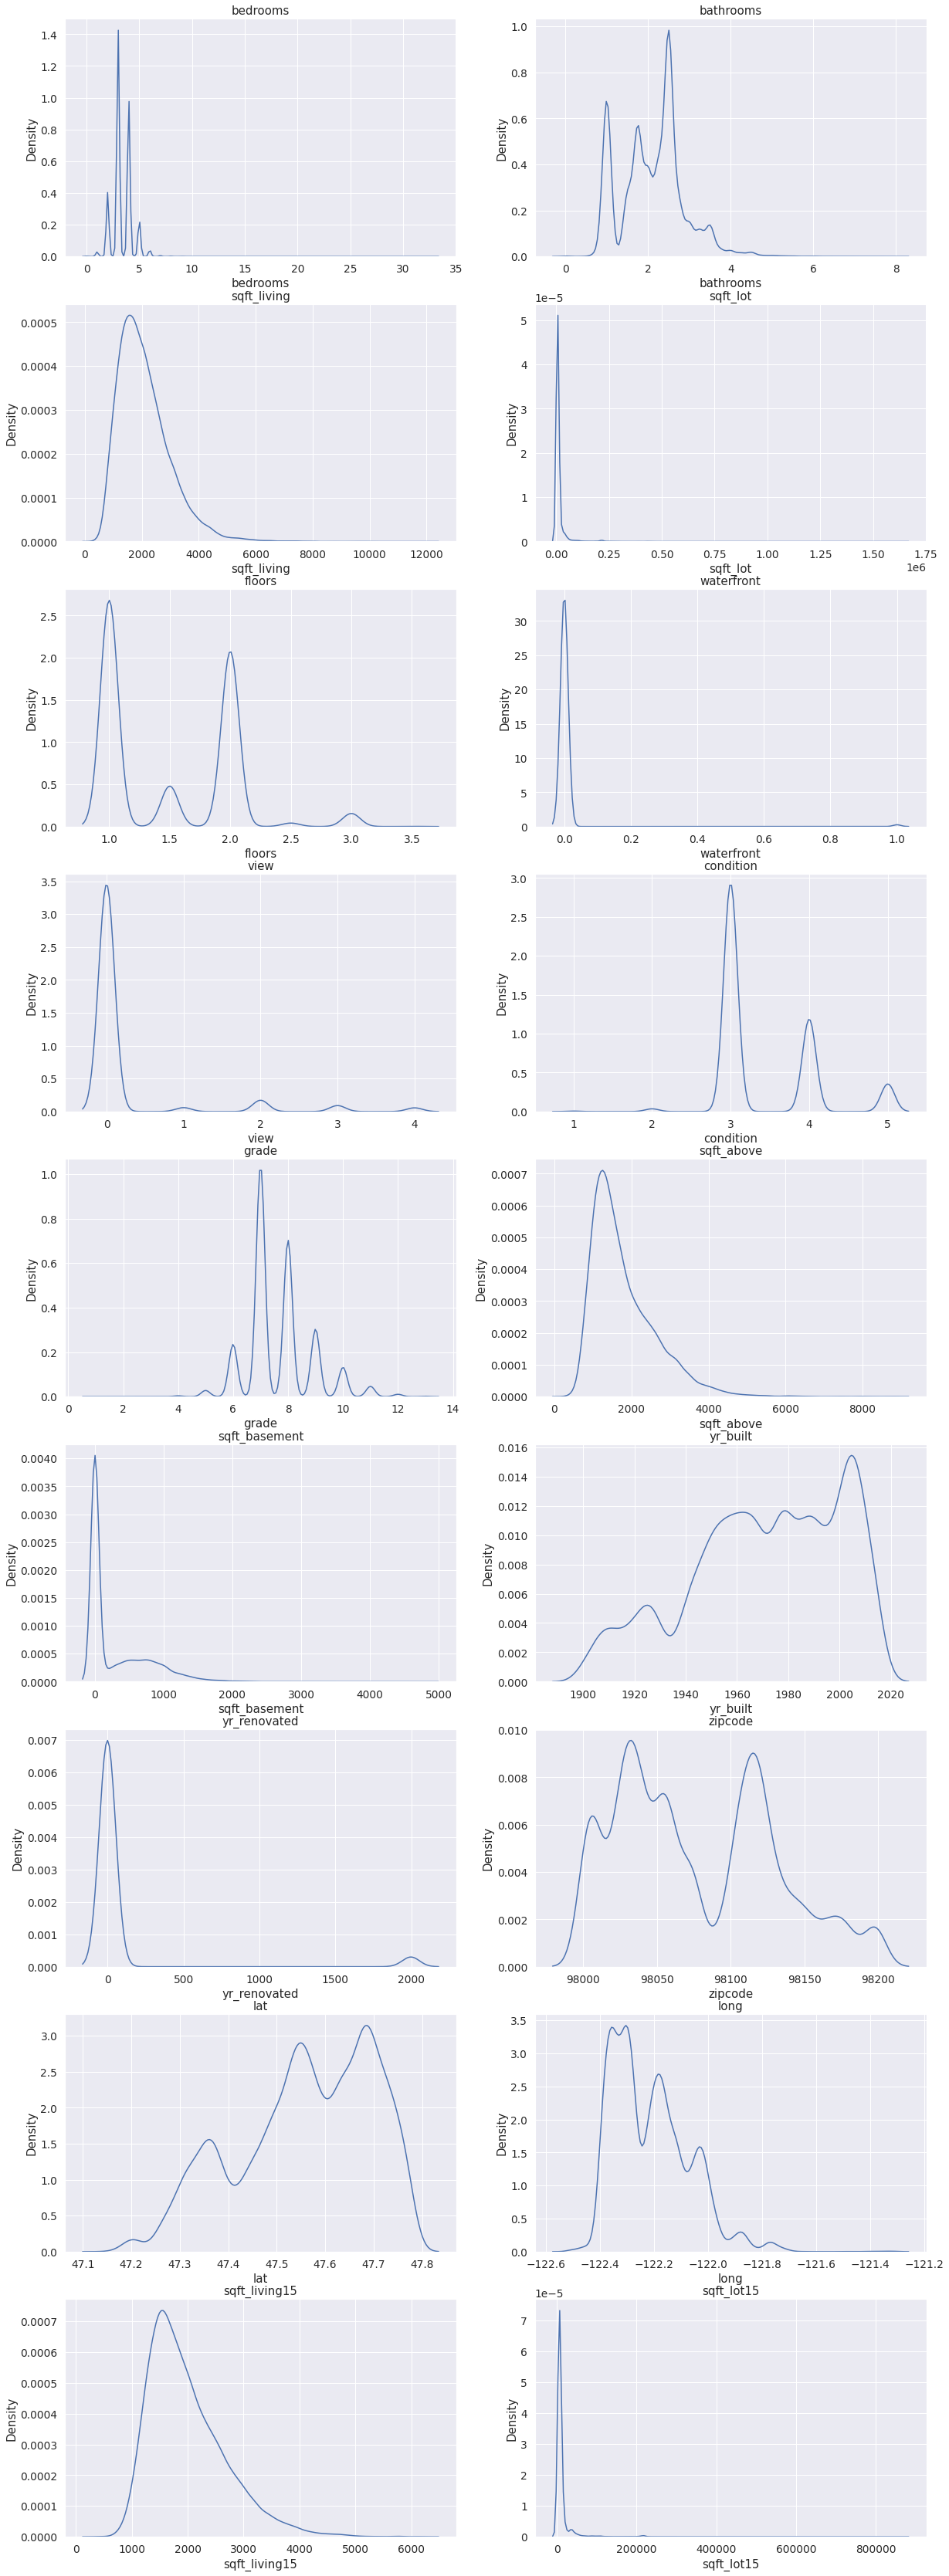

In [1510]:
fig, ax = plt.subplots(9, 2, figsize=(20, 60))

# id 변수는 제외하고 분포를 확인합니다.
count = 1
columns = total_data.columns[2:] # id와 datetime을 뺀다.
for ax_item, column in zip(ax.flat, columns):
    sns.kdeplot(total_data[column], ax=ax_item)
    ax_item.set_title(column, fontsize=15)


bedrooms, sqft_living, sqft_lot, sqft_above, sqft_basement 변수가 한쪽으로 치우친 경향을 보이므로    
log-scaling으로 데이터 분포를 정규분포에 가깝게 만들어보자.
(한쪽으로 치우쳐도 카테고리형 데이터인 경우 제외하였다.)

In [1511]:
normal_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for column in normal_columns:
    total_data[column] = np.log1p(total_data[column].values)

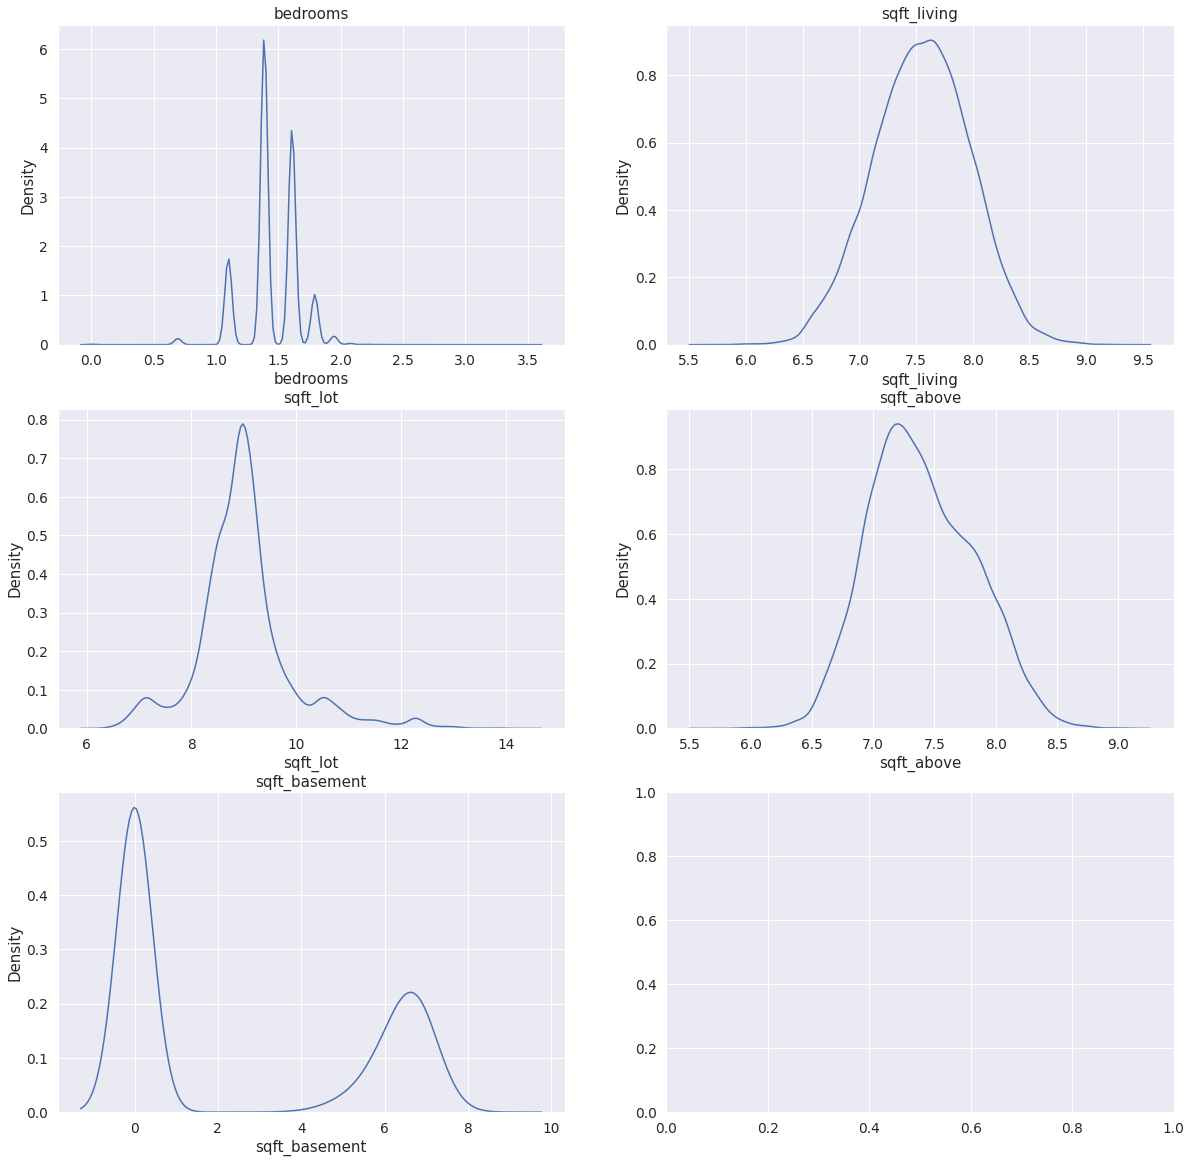

In [1512]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20))

# id 변수는 제외하고 분포를 확인합니다.
for ax_item, column in zip(ax.flat, normal_columns):
    sns.kdeplot(total_data[column], ax=ax_item)
    ax_item.set_title(column, fontsize=15)


### 변수 수정

#### id, date 정리
id는 데이터의 고유한 아이디이므로 예측하는데 필요가 없고, date의 경우 연월만 고려하는 범주형 변수로 만든다.

In [1513]:
test_id = total_data['id'][train_len:] # test dataset id의 경우 따로 저장한다.
del total_data['id']
total_data.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
0  20141013T000000  1.386294       1.00     7.074117  8.639588     1.0   
1  20150225T000000  1.098612       1.00     6.647688  9.210440     1.0   
2  20150218T000000  1.386294       2.00     7.427144  8.997271     1.0   
3  20140627T000000  1.386294       2.25     7.447751  8.827615     2.0   
4  20150115T000000  1.386294       1.50     6.966967  9.181118     1.0   

   waterfront  view  condition  grade  sqft_above  sqft_basement  yr_built  \
0           0     0          3      7    7.074117            0.0      1955   
1           0     0          3      6    6.647688            0.0      1933   
2           0     0          3      8    7.427144            0.0      1987   
3           0     0          3      7    7.447751            0.0      1995   
4           0     0          3      7    6.966967            0.0      1963   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0             0    98178  47.5112 -122.257           1340        5650  
1             0    98028  47.7379 -122.233           2720        8062  
2             0    98074  47.6168 -122.045           1800        7503  
3             0    98003  47.3097 -122.327           2238        6819  
4             0    98198  47.4095 -122.315           1650        9711

In [1514]:
total_data['date'] = total_data['date'].apply(lambda x : str(x[:6])).astype(str)
total_data.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201410  1.386294       1.00     7.074117  8.639588     1.0           0   
1  201502  1.098612       1.00     6.647688  9.210440     1.0           0   
2  201502  1.386294       2.00     7.427144  8.997271     1.0           0   
3  201406  1.386294       2.25     7.447751  8.827615     2.0           0   
4  201501  1.386294       1.50     6.966967  9.181118     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7    7.074117            0.0      1955             0   
1     0          3      6    6.647688            0.0      1933             0   
2     0          3      8    7.427144            0.0      1987             0   
3     0          3      7    7.447751            0.0      1995             0   
4     0          3      7    6.966967            0.0      1963             0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503  
3    98003  47.3097 -122.327           2238        6819  
4    98198  47.4095 -122.315           1650        9711

yr_renovated=0인경우 집을 재건축하지 않았다는 의미이다. 따라서 yr_built(지어진 년도)를 넣어준다.

In [1515]:
total_data['yr_renovated'] = total_data['yr_renovated'].apply(lambda x: np.nan if x==0 else x)
total_data['yr_renovated'] = total_data['yr_renovated'].fillna(total_data['yr_built'])

### 변수 생성

In [1516]:
total_data.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201410  1.386294       1.00     7.074117  8.639588     1.0           0   
1  201502  1.098612       1.00     6.647688  9.210440     1.0           0   
2  201502  1.386294       2.00     7.427144  8.997271     1.0           0   
3  201406  1.386294       2.25     7.447751  8.827615     2.0           0   
4  201501  1.386294       1.50     6.966967  9.181118     1.0           0   

   view  condition  grade  sqft_above  sqft_basement  yr_built  yr_renovated  \
0     0          3      7    7.074117            0.0      1955        1955.0   
1     0          3      6    6.647688            0.0      1933        1933.0   
2     0          3      8    7.427144            0.0      1987        1987.0   
3     0          3      7    7.447751            0.0      1995        1995.0   
4     0          3      7    6.966967            0.0      1963        1963.0   

   zipcode      lat     long  sqft_living15  sqft_lot15  
0    98178  47.5112 -122.257           1340        5650  
1    98028  47.7379 -122.233           2720        8062  
2    98074  47.6168 -122.045           1800        7503  
3    98003  47.3097 -122.327           2238        6819  
4    98198  47.4095 -122.315           1650        9711

In [1517]:
# 방 전체 개수
total_data['total_rooms'] = total_data['bedrooms']+total_data['bathrooms']
# 실거주 면적 비율
total_data['sqft_ratio'] = total_data['sqft_living']/total_data['sqft_lot']
# 지상층, 지하층 면적의 합
total_data['sqft_total_size'] = total_data['sqft_above']+total_data['sqft_basement']
# 전체 면적 대비 실거주 면적 비율
total_data['sqft_ratio_1'] = total_data['sqft_living']/total_data['sqft_total_size']
total_data['sqft_ratio_15'] = total_data['sqft_living15']/total_data['sqft_lot15']
# 재건축 여부
total_data['is_renovated'] = total_data['yr_renovated'] - total_data['yr_built']
total_data['is_renovated'] = total_data['is_renovated'].apply(lambda x: 0 if x==0 else 1)
total_data['date'] = total_data['date'].astype('int')

다시 원래의 데이터셋으로 되돌린다.

In [1518]:
train_data = total_data.iloc[:train_len, :].copy()
test_data = total_data.iloc[train_len:, :].copy()

In [1519]:
train_data['price']=y

집값의 경우 비슷한 지역에 영향을 받는다. 주의할 것은 평당 가격을 써야한다는 것이다.

In [1520]:
# 평당 가격
train_data['per_price'] = train_data['price']/train_data['sqft_total_size']

In [1521]:
train_data.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201410  1.386294       1.00     7.074117  8.639588     1.0           0   
1  201502  1.098612       1.00     6.647688  9.210440     1.0           0   
2  201502  1.386294       2.00     7.427144  8.997271     1.0           0   
3  201406  1.386294       2.25     7.447751  8.827615     2.0           0   
4  201501  1.386294       1.50     6.966967  9.181118     1.0           0   

   view  condition  grade  ...  sqft_living15  sqft_lot15  total_rooms  \
0     0          3      7  ...           1340        5650     2.386294   
1     0          3      6  ...           2720        8062     2.098612   
2     0          3      8  ...           1800        7503     3.386294   
3     0          3      7  ...           2238        6819     3.636294   
4     0          3      7  ...           1650        9711     2.886294   

   sqft_ratio  sqft_total_size  sqft_ratio_1  sqft_ratio_15  is_renovated  \
0    0.818803         7.074117           1.0       0.237168             0   
1    0.721756         6.647688           1.0       0.337385             0   
2    0.825489         7.427144           1.0       0.239904             0   
3    0.843688         7.447751           1.0       0.328201             0   
4    0.758837         6.966967           1.0       0.169910             0   

       price  per_price  
0  12.309987   1.740145  
1  12.100718   1.820290  
2  13.142168   1.769478  
3  12.458779   1.672824  
4  12.583999   1.806238  

[5 rows x 27 columns]

In [1522]:
zipcode_per_price = train_data.groupby(['zipcode'])['per_price'].agg({'mean', 'var'}).reset_index()
zipcode_per_price

zipcode      mean       var
0     98001  1.490736  0.110772
1     98002  1.559377  0.086592
2     98003  1.426763  0.135985
3     98004  1.427774  0.174133
4     98005  1.307652  0.162820
..      ...       ...       ...
65    98177  1.331077  0.165147
66    98178  1.324285  0.171641
67    98188  1.469849  0.139837
68    98198  1.439939  0.143851
69    98199  1.169488  0.119915

[70 rows x 3 columns]

In [1523]:
train_data = pd.merge(train_data, zipcode_per_price, how='left', on='zipcode')
test_data = pd.merge(test_data, zipcode_per_price, how='left', on='zipcode')

for df in [train_data, test_data]:
    df['zipcode_mean'] = df['mean']*df['sqft_total_size']
    df['zipcode_var'] = df['var']*df['sqft_total_size']
    del df['mean']
    del df['var']

In [1524]:
train_data.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201410  1.386294       1.00     7.074117  8.639588     1.0           0   
1  201502  1.098612       1.00     6.647688  9.210440     1.0           0   
2  201502  1.386294       2.00     7.427144  8.997271     1.0           0   
3  201406  1.386294       2.25     7.447751  8.827615     2.0           0   
4  201501  1.386294       1.50     6.966967  9.181118     1.0           0   

   view  condition  grade  ...  total_rooms  sqft_ratio  sqft_total_size  \
0     0          3      7  ...     2.386294    0.818803         7.074117   
1     0          3      6  ...     2.098612    0.721756         6.647688   
2     0          3      8  ...     3.386294    0.825489         7.427144   
3     0          3      7  ...     3.636294    0.843688         7.447751   
4     0          3      7  ...     2.886294    0.758837         6.966967   

   sqft_ratio_1  sqft_ratio_15  is_renovated      price  per_price  \
0           1.0       0.237168             0  12.309987   1.740145   
1           1.0       0.337385             0  12.100718   1.820290   
2           1.0       0.239904             0  13.142168   1.769478   
3           1.0       0.328201             0  12.458779   1.672824   
4           1.0       0.169910             0  12.583999   1.806238   

   zipcode_mean  zipcode_var  
0      9.368147     1.214207  
1      9.257745     1.023549  
2     11.307711     0.826257  
3     10.626177     1.012780  
4     10.032009     1.002206  

[5 rows x 29 columns]

In [1525]:
test_data.head()

date  bedrooms  bathrooms  sqft_living   sqft_lot  floors  waterfront  \
0  201412  1.386294       2.25     7.852050   8.887791     2.0           0   
1  201412  1.609438       3.00     7.581210   8.517393     1.0           0   
2  201405  1.609438       4.50     8.598036  11.532051     1.0           0   
3  201504  1.386294       1.00     7.484930   8.918784     1.0           0   
4  201503  1.386294       2.50     7.544861   8.788898     2.0           0   

   view  condition  grade  ...  sqft_living15  sqft_lot15  total_rooms  \
0     0          3      7  ...           1690        7639     3.636294   
1     0          5      7  ...           1360        5000     4.609438   
2     0          3     11  ...           4760      101930     6.109438   
3     0          3      7  ...           1780        8113     2.386294   
4     0          3      7  ...           2390        7570     3.886294   

   sqft_ratio  sqft_total_size  sqft_ratio_1  sqft_ratio_15  is_renovated  \
0    0.883465        13.676905      0.574110       0.221233             1   
1    0.890086        13.772040      0.550478       0.272000             0   
2    0.745577        15.600098      0.551153       0.046699             0   
3    0.839232        13.551911      0.552315       0.219401             0   
4    0.858454         7.544861      1.000000       0.315720             0   

   zipcode_mean  zipcode_var  
0     19.243241     2.317027  
1     18.113257     2.389816  
2     25.917920     0.737584  
3     19.759625     2.053191  
4     11.947244     0.477170  

[5 rows x 27 columns]

In [1526]:
y_price = train_data[['price', 'per_price']]
del train_data['price']
del train_data['per_price']

# 사용하는 함수 만들기

In [1527]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from scipy.stats import uniform, randint

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

In [1528]:
# 위 전처리 과정에서 log1p로 변환했기 때문에 원래 데이터 단위로 돌려야 한다.
def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))

In [1529]:
# 모델의 성능을 계산하는 함수
def get_score(models, train, y):
    df = {}
    for model in models:
        random_state = 20000
        model_name = model.__class__.__name__
        X_train, X_test, y_train, y_test = train_test_split(train, y, random_state = random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False)
    return df

In [1530]:
# Randomized Search를 이용한 CrossValidation
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

def get_cv_score(model, train, y, param_grid, random_state):
    rcv = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, verbose=1, n_jobs=5, return_train_score=True)
    rcv.fit(train, y)
    
    score_df = pd.DataFrame(rcv.cv_results_['params'])
    score_df['score'] = rcv.cv_results_['mean_test_score']
    score_df['RMSLE'] = np.sqrt(-1*score_df['score'])
    score_df = score_df.sort_values(by='RMSLE', ascending=False)
    # print(f"Model {model.__class__.__name__} best RMSLE score: {score_df['RMSLE'].iloc[0]}")
    print(f"Model {model.__class__.__name__}")
    return score_df

In [1531]:
# submission 파일 생성하는 함수
def save_submission(model, train, y, test,model_name, rmsle=None):
    model.fit(train, y)
    y_pred = model.predict(test)
    y_pred = np.expm1(y_pred)
    data_root_path = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_root_path, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission['price'] = y_pred
    submission_file_name = f'submision_{model_name}_RMSLE_{rmsle}.csv'
    submission.to_csv(join(data_root_path, submission_file_name), index=False)
    print(f'{join(data_root_path, submission_file_name)} saved')
    

# Baseline
Average Blending을 사용해 성능을 높이려고 한다.

In [1532]:
gboost = GradientBoostingRegressor(random_state=2019)
xgboost = xgb.XGBRegressor(random_state=2019)
lightgbm = lgb.LGBMRegressor(random_state=2019)

models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

#### 간단한 성능 평가

In [1533]:
kfold = KFold(n_splits=5, random_state=2019, shuffle=True).get_n_splits(train_data.values)
for m in models:
    print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train_data.values, y_price['price'])), 
                                         kf=kfold))

Model GradientBoosting CV score : 0.8792
Model XGBoost CV score : 0.8952
Model LightGBM CV score : 0.9014


In [1534]:
def AveragingBlending(models, train, y, test):
    fold_importance_df = pd.DataFrame()
    for m in models:
        m['model'].fit(train.values, y)
                
        fold_importance_df['feature'] = train.columns.tolist()
        fold_importance_df['importance'] = m['model'].feature_importances_        
        
    y_pred = np.column_stack([
        m['model'].predict(test.values) for m in models
    ])
    return np.mean(y_pred, axis=1), fold_importance_df

In [1537]:
y_pred,fi_df = AveragingBlending(models, train_data,y_price['price'], test_data)

In [1538]:
y_pred = np.expm1(y_pred)

In [1539]:
data_root_path = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
submission_path = join(data_root_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = y_pred
submission_file_name = f'submision_average_blending_RMSLE.csv'
submission.to_csv(join(data_root_path, submission_file_name), index=False)

<img width="1192" alt="스크린샷 2021-08-10 오후 4 03 01" src="https://user-images.githubusercontent.com/63278762/128822895-9dd2a3e6-0509-4b89-8bcd-7bdd3e57d56b.png">


# 성능 개선

### Feature Engineering
https://www.kaggle.com/tmheo74/geo-data-eda-and-feature-engineering    
(위치에 관련된 feature engineering을 진행한 노트북이라 참고했습니다.)

In [1540]:
train_data['zipcode'].head()

0    98178
1    98028
2    98074
3    98003
4    98198
Name: zipcode, dtype: int64

zipcode를 보면 앞에 98로 동일하고, 뒤 3자리만 다른 것을 볼 수 있다.     
뒤 3자리를 쪼개서 feature를 생성해보자.

In [1541]:
for m in [train_data, test_data]: 
    str_zipcode = train_data['zipcode'].astype(str)
    m['zipcode_3'] = 'z_'+str_zipcode.str[2:3]
    m['zipcode_4'] = 'z_'+str_zipcode.str[3:4]
    m['zipcode_5'] = 'z_'+str_zipcode.str[4:5]
    m['zipcode_34'] = 'z_'+str_zipcode.str[2:4]
    m['zipcode_35'] = 'z_'+str_zipcode.str[2:3] +str_zipcode.str[4:5]
    m['zipcode_45'] = 'z_'+str_zipcode.str[3:5]

In [1542]:
train_data.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201410  1.386294       1.00     7.074117  8.639588     1.0           0   
1  201502  1.098612       1.00     6.647688  9.210440     1.0           0   
2  201502  1.386294       2.00     7.427144  8.997271     1.0           0   
3  201406  1.386294       2.25     7.447751  8.827615     2.0           0   
4  201501  1.386294       1.50     6.966967  9.181118     1.0           0   

   view  condition  grade  ...  sqft_ratio_15  is_renovated  zipcode_mean  \
0     0          3      7  ...       0.237168             0      9.368147   
1     0          3      6  ...       0.337385             0      9.257745   
2     0          3      8  ...       0.239904             0     11.307711   
3     0          3      7  ...       0.328201             0     10.626177   
4     0          3      7  ...       0.169910             0     10.032009   

   zipcode_var  zipcode_3  zipcode_4  zipcode_5  zipcode_34  zipcode_35  \
0     1.214207        z_1        z_7        z_8        z_17        z_18   
1     1.023549        z_0        z_2        z_8        z_02        z_08   
2     0.826257        z_0        z_7        z_4        z_07        z_04   
3     1.012780        z_0        z_0        z_3        z_00        z_03   
4     1.002206        z_1        z_9        z_8        z_19        z_18   

   zipcode_45  
0        z_78  
1        z_28  
2        z_74  
3        z_03  
4        z_98  

[5 rows x 33 columns]

In [1543]:
test_data.head()

date  bedrooms  bathrooms  sqft_living   sqft_lot  floors  waterfront  \
0  201412  1.386294       2.25     7.852050   8.887791     2.0           0   
1  201412  1.609438       3.00     7.581210   8.517393     1.0           0   
2  201405  1.609438       4.50     8.598036  11.532051     1.0           0   
3  201504  1.386294       1.00     7.484930   8.918784     1.0           0   
4  201503  1.386294       2.50     7.544861   8.788898     2.0           0   

   view  condition  grade  ...  sqft_ratio_15  is_renovated  zipcode_mean  \
0     0          3      7  ...       0.221233             1     19.243241   
1     0          5      7  ...       0.272000             0     18.113257   
2     0          3     11  ...       0.046699             0     25.917920   
3     0          3      7  ...       0.219401             0     19.759625   
4     0          3      7  ...       0.315720             0     11.947244   

   zipcode_var  zipcode_3  zipcode_4  zipcode_5  zipcode_34  zipcode_35  \
0     2.317027        z_1        z_7        z_8        z_17        z_18   
1     2.389816        z_0        z_2        z_8        z_02        z_08   
2     0.737584        z_0        z_7        z_4        z_07        z_04   
3     2.053191        z_0        z_0        z_3        z_00        z_03   
4     0.477170        z_1        z_9        z_8        z_19        z_18   

   zipcode_45  
0        z_78  
1        z_28  
2        z_74  
3        z_03  
4        z_98  

[5 rows x 33 columns]

#### 기존 지도

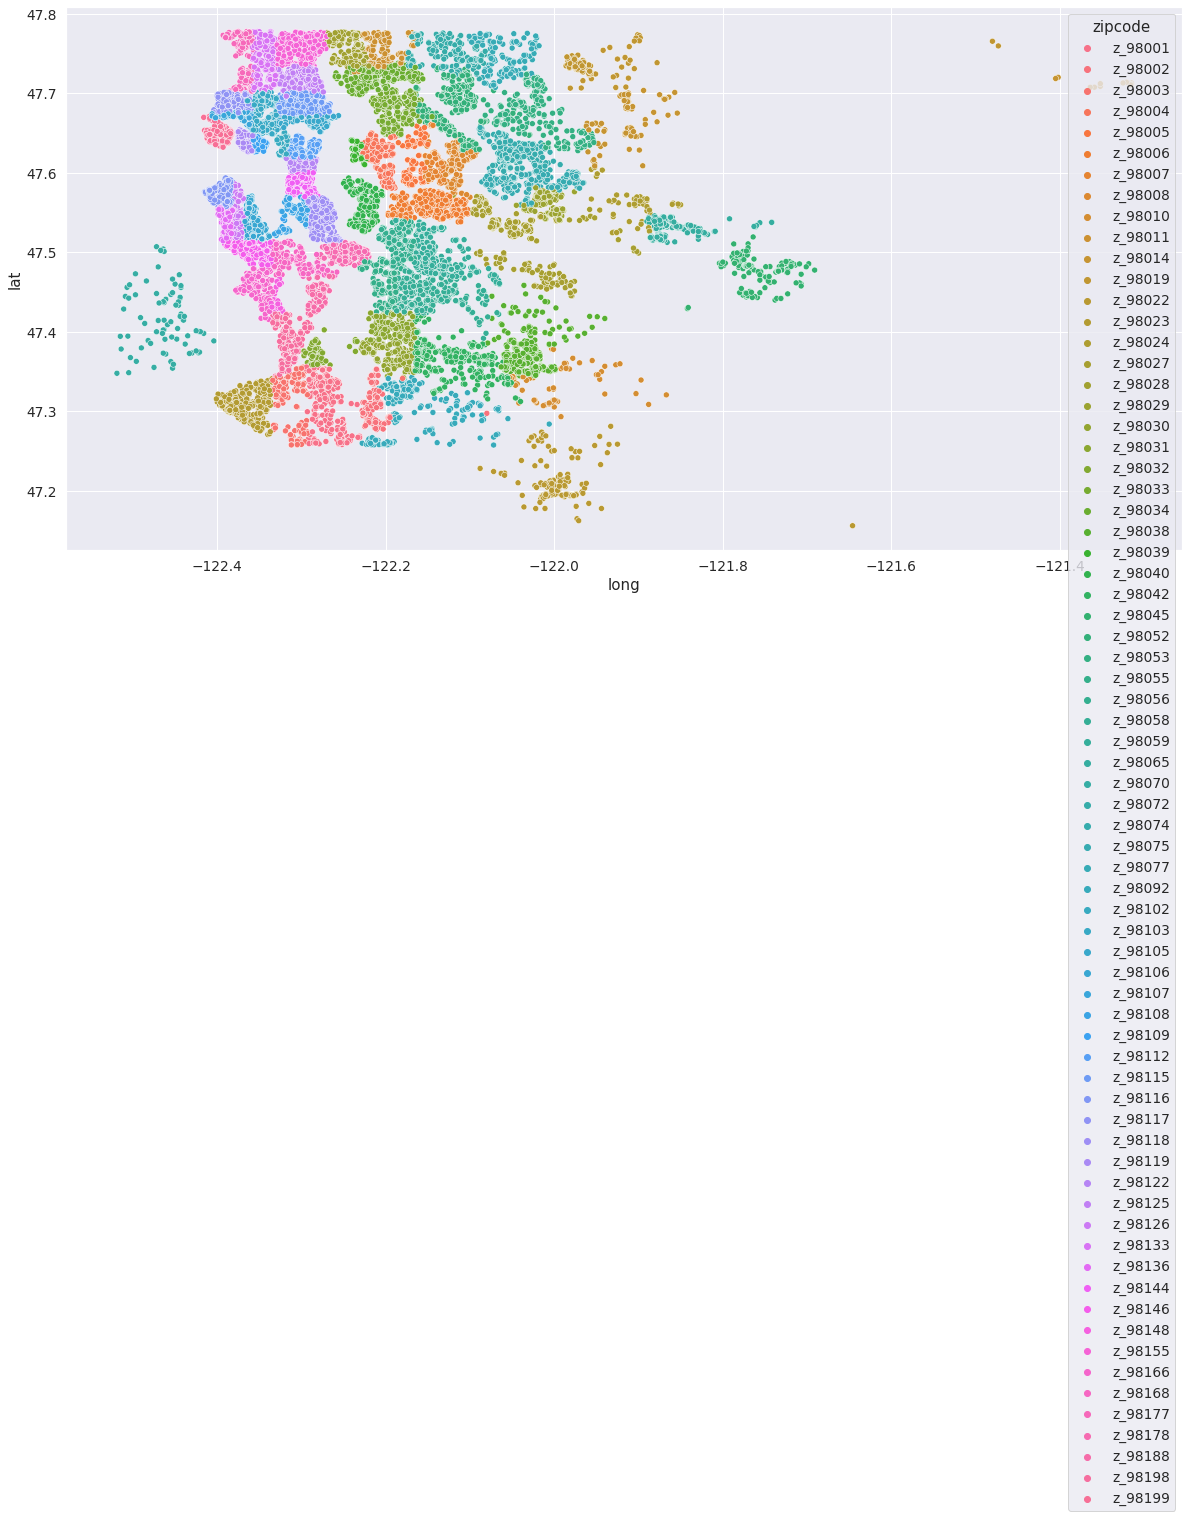

In [1544]:
plt.figure(figsize=(20,10))
train_temp = train_data.copy()
train_temp['zipcode'] = train_temp['zipcode'].astype(str)
train_temp['zipcode'] = 'z_' + train_temp['zipcode']
sns.scatterplot(data = train_temp, x='long', y='lat', hue='zipcode', hue_order=np.sort(train_temp['zipcode'].unique()));

In [1545]:
plt.figure(figsize=(20,10))
sns.scatterplot(data = train_data, x='long', y='lat', hue='zipcode_3', hue_order=np.sort(train_data['zipcode_3'].unique()));

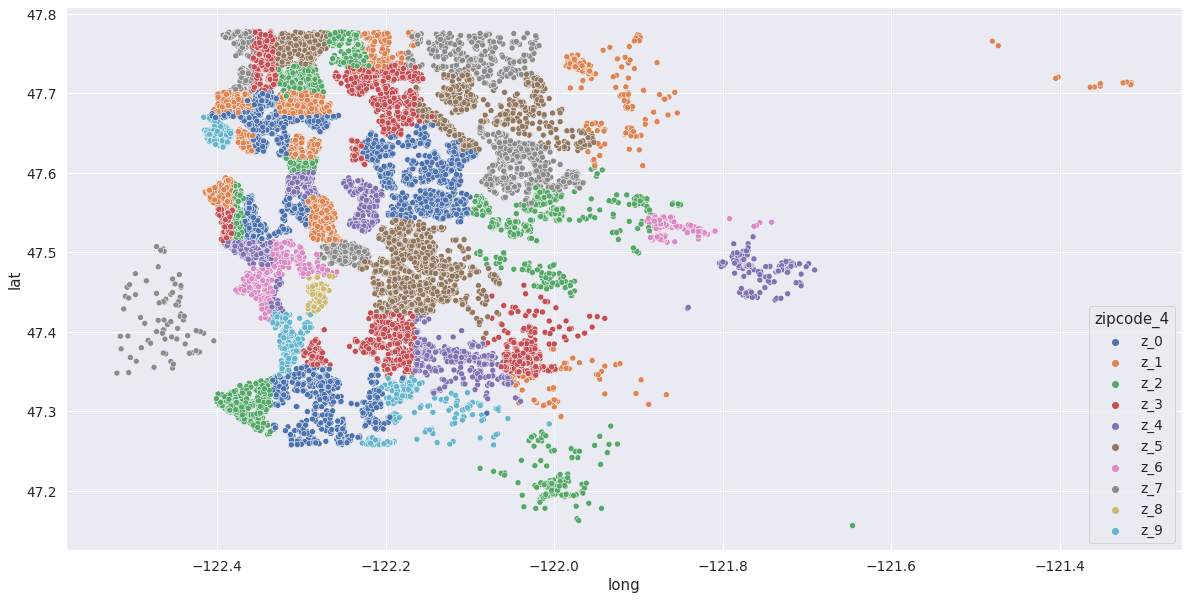

In [1546]:
plt.figure(figsize=(20,10))
sns.scatterplot(data = train_data, x='long', y='lat', hue='zipcode_4', hue_order=np.sort(train_data['zipcode_4'].unique()));

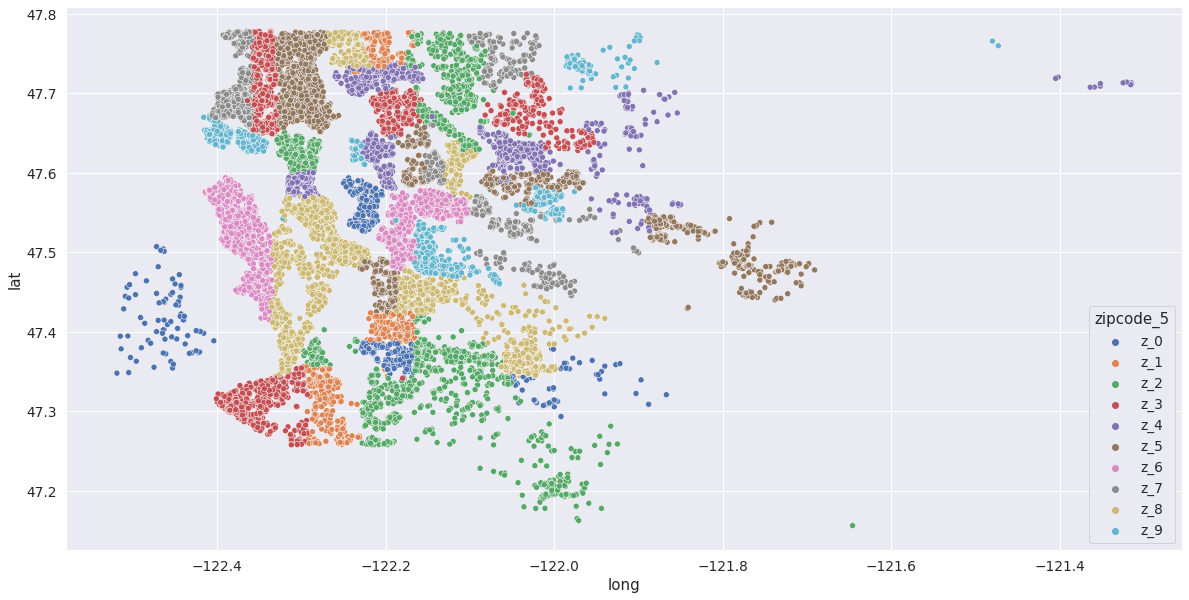

In [1547]:
plt.figure(figsize=(20,10))
sns.scatterplot(data = train_data, x='long', y='lat', hue='zipcode_5', hue_order=np.sort(train_data['zipcode_5'].unique()));

In [1548]:
plt.figure(figsize=(20,10))
sns.scatterplot(data = train_data, x='long', y='lat', hue='zipcode_34', hue_order=np.sort(train_data['zipcode_34'].unique()));

In [1549]:
plt.figure(figsize=(20,10))
sns.scatterplot(data = train_data, x='long', y='lat', hue='zipcode_45', hue_order=np.sort(train_data['zipcode_45'].unique()));

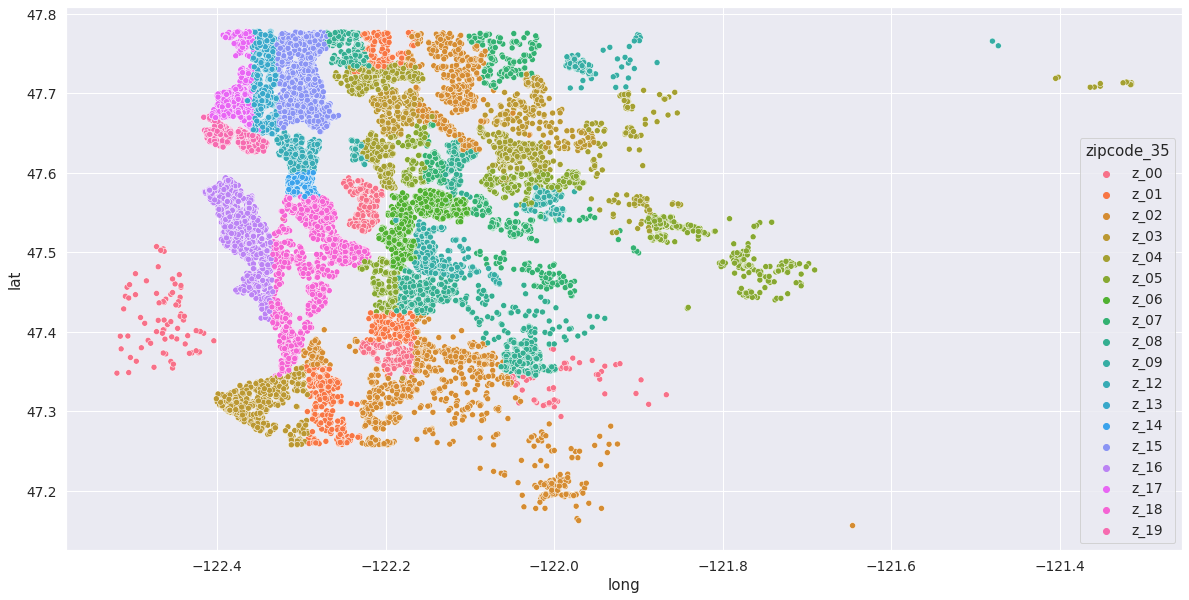

In [1550]:
plt.figure(figsize=(20,10))
sns.scatterplot(data = train_data, x='long', y='lat', hue='zipcode_35', hue_order=np.sort(train_data['zipcode_35'].unique()));

위 시각화로 zipcode를 분해하면 행정구역이 나오는 것을 알 수 있다.  
zipcode는 결국 행정구역에 대한 정보를 가지고 있으므로 카테고리형 데이터로 봐야한다.    
zipcode를 str로 변환 후 One Hot Encoding 했다.

In [1551]:
train_data['zipcode'] = 'z_' + train_data['zipcode'].astype(str)
test_data['zipcode'] = 'z_' + test_data['zipcode'].astype(str)

In [1552]:
# train
cat_cols = train_data.select_dtypes('object').columns
for col in cat_cols:
    ohe_df = pd.get_dummies(train_data[[col]], prefix='ohe_'+col)
    train_data.drop(col, axis=1, inplace=True)
    train_data = pd.concat([train_data, ohe_df], axis=1)


In [1553]:
# test
cat_cols = test_data.select_dtypes('object').columns
for col in cat_cols:
    ohe_df = pd.get_dummies(test_data[[col]], prefix='ohe_'+col)
    test_data.drop(col, axis=1, inplace=True)
    test_data = pd.concat([test_data, ohe_df], axis=1)
        

In [1554]:
train_data.head()

date  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  201410  1.386294       1.00     7.074117  8.639588     1.0           0   
1  201502  1.098612       1.00     6.647688  9.210440     1.0           0   
2  201502  1.386294       2.00     7.427144  8.997271     1.0           0   
3  201406  1.386294       2.25     7.447751  8.827615     2.0           0   
4  201501  1.386294       1.50     6.966967  9.181118     1.0           0   

   view  condition  grade  ...  ohe_zipcode_45_z_70  ohe_zipcode_45_z_72  \
0     0          3      7  ...                    0                    0   
1     0          3      6  ...                    0                    0   
2     0          3      8  ...                    0                    0   
3     0          3      7  ...                    0                    0   
4     0          3      7  ...                    0                    0   

   ohe_zipcode_45_z_74  ohe_zipcode_45_z_75  ohe_zipcode_45_z_77  \
0                    0                    0                    0   
1                    0                    0                    0   
2                    1                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   ohe_zipcode_45_z_78  ohe_zipcode_45_z_88  ohe_zipcode_45_z_92  \
0                    1                    0                    0   
1                    0                    0                    0   
2                    0                    0                    0   
3                    0                    0                    0   
4                    0                    0                    0   

   ohe_zipcode_45_z_98  ohe_zipcode_45_z_99  
0                    0                    0  
1                    0                    0  
2                    0                    0  
3                    0                    0  
4                    1                    0  

[5 rows x 214 columns]

In [1555]:
train_data.shape, test_data.shape

((15030, 214), (6468, 214))

In [1556]:
kfold = KFold(n_splits=5, random_state=2019, shuffle=True).get_n_splits(train_data.values)

for m in models:
    print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train_data.values, y_price['price'])), 
                                         kf=kfold))

Model GradientBoosting CV score : 0.8822
Model XGBoost CV score : 0.8977
Model LightGBM CV score : 0.9034


In [1557]:
y_pred, fi_df = AveragingBlending(models, train_data,y_price['price'], test_data)

<AxesSubplot:xlabel='importance', ylabel='feature'>

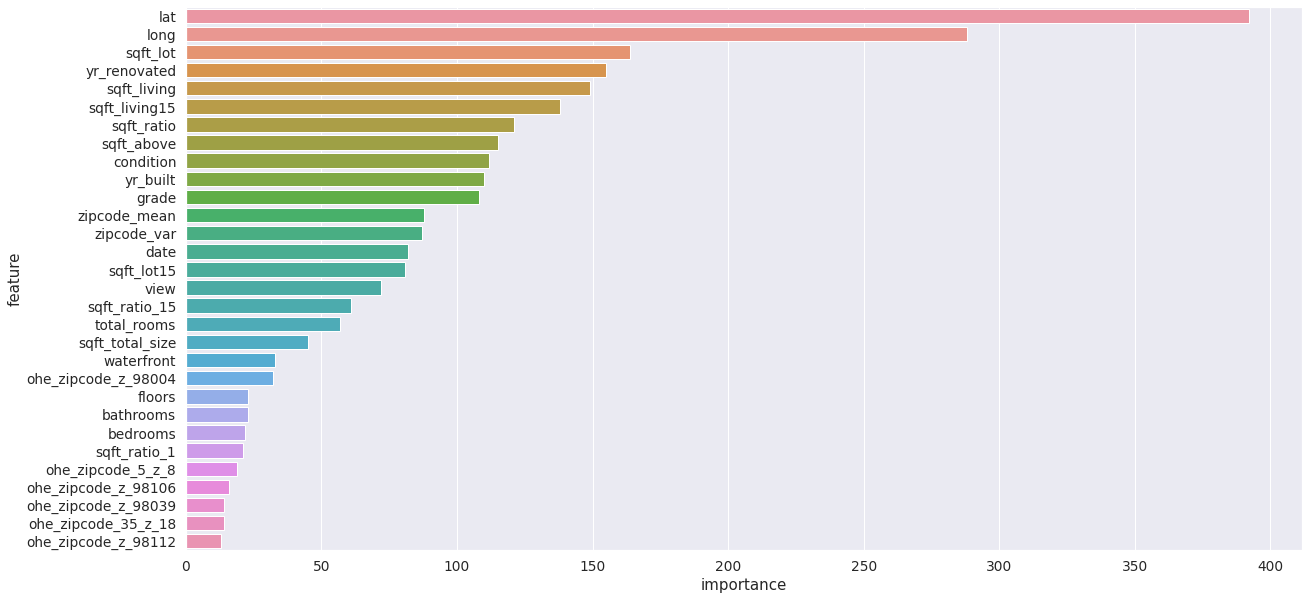

In [1558]:
cols = (fi_df[['feature', 'importance']]
            .groupby('feature')
            .mean()
            .sort_values(by='importance', ascending=False)[:30].index)
best_features = fi_df.loc[fi_df.feature.isin(cols)]
plt.figure(figsize=(20,10))
sns.barplot(x='importance', y='feature', data=best_features.sort_values(by='importance', ascending=False))

### 확인

In [1603]:
gboost = GradientBoostingRegressor(random_state=2021)
xgboost = xgb.XGBRegressor(random_state=2021)
lightgbm = lgb.LGBMRegressor(random_state=2021)

In [1604]:
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

kfold = KFold(n_splits=5, random_state=2021, shuffle=True).get_n_splits(train_data.values)
for m in models:
    print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train_data.values, y_price['price'])), 
                                         kf=kfold))

Model GradientBoosting CV score : 0.8822
Model XGBoost CV score : 0.8977
Model LightGBM CV score : 0.9034


In [1628]:
lightgbm = LGBMRegressor(random_state=2021)                      

In [1629]:
gboost = GradientBoostingRegressor(random_state=2021, max_depth=4)
#                                   n_estimators=200,
#                                   max_depth=3,
#                                   learning_rate=0.01,
#                                   min_samples_split=0.8)

In [1571]:
xgboost = xgb.XGBRegressor(random_state=2021)
#                           n_estimators=200,
#                           max_depth=6,
#                           learning_rate=0.01,
#                           subsample=0.8)

In [1630]:
models = [{'model':gboost, 'name':'GradientBoosting'}, {'model':xgboost, 'name':'XGBoost'},
          {'model':lightgbm, 'name':'LightGBM'}]

In [1631]:
kfold = KFold(n_splits=5, random_state=2019, shuffle=True).get_n_splits(train_data.values)
for m in models:
    print("Model {} CV score : {:.4f}".format(m['name'], np.mean(cross_val_score(m['model'], train_data.values, y_price['price'])), 
                                         kf=kfold))

Model GradientBoosting CV score : 0.8931
Model XGBoost CV score : 0.8977
Model LightGBM CV score : 0.9034


In [1632]:
y_pred, fi_df = AveragingBlending(models, train_data,y_price['price'], test_data)

In [1633]:
y_pred = np.expm1(y_pred)

In [1634]:
data_root_path = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
submission_path = join(data_root_path, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission['price'] = y_pred
submission_file_name = f'submision_average_blending_RMSLE_2.csv'
submission.to_csv(join(data_root_path, submission_file_name), index=False)

### 위 모델의 결과
<img width="1192" alt="스크린샷 2021-08-10 오후 11 48 16" src="https://user-images.githubusercontent.com/63278762/128888570-75b84e7c-fc1d-4c02-8740-43e0755fc4cc.png">

# 회고
* 해커톤 후에 하는 캐글이라 더 잘 하고 싶었는데 생각만큼 점수가 낮춰지지 않아서 아쉬웠다.
* 많은 캐글 노트북을 보고 필사를 하면서 feature engineering과 하이퍼파라미터 튜닝에 대한 감각을 길러야겠다고 생각했다.
* feature engineering을 했는데 오히려 점수가 높아진 현상이 나타났다. feature engineering이 문제일까 모델 하이퍼파라미터가 문제였을까??

# Reference
* https://www.kaggle.com/chocozzz/house-price-prediction-eda-updated-2019-03-12
* https://teddylee777.github.io/scikit-learn/scikit-learn-ensemble